**Statistical analysis of GoFast scooter rental service mobile application data**

Let's analyze the data obtained from the mobile application.


The GoFast service can be used:

**No subscription:**
- there is no subscription fee;
- the cost of one minute of a trip - 8 rubles;
- the cost of the start (beginning of the trip) - 50 rubles;

**With an Ultra subscription:**
- subscription fee - 199 rubles per month;
- cost of one minute of a trip - 6 rubles;
- the cost of the start - free of charge.

Work plan:


1. Data loading
2. Data preprocessing
3. exploratory data analysis
4. data fusion
5. Revenue calculation
6. Hypothesis testing
7. Distributions

----------------------

Import all the libraries that will be needed for the job.

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from scipy.stats import binom

Let's set the main variables and read data from csv files.

In [36]:
try:
    users_go = pd.read_csv('/datasets/users_go.csv')
    rides_go = pd.read_csv('/datasets/rides_go.csv')
    subscriptions_go = pd.read_csv('/datasets/subscriptions_go.csv')

except:
    users_go = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')
    rides_go = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')
    subscriptions_go = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')

Let's display the first rows of the tables to familiarize ourselves with the data record format.

In [37]:
display('Таблица users_go:', users_go.head(),)
display('Таблица rides_go:', rides_go.head(),)
display('Таблица subscriptions_go:', subscriptions_go)


'Таблица users_go:'

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


'Таблица rides_go:'

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


'Таблица subscriptions_go:'

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Let's familiarize ourselves with general information about dataframes.

In [38]:
print(users_go.info())
print('Number of apparent duplicates in `users_go.csv` = ', users_go.duplicated().sum())
print(rides_go.info())
print('Number of apparent duplicates in `rides_go.csv` = ', rides_go.duplicated().sum())
print(subscriptions_go.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
None
Number of apparent duplicates in `users_go.csv` =  31
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB
None
Number of apparent duplicates in `rides_go.c

Let's draw histograms.

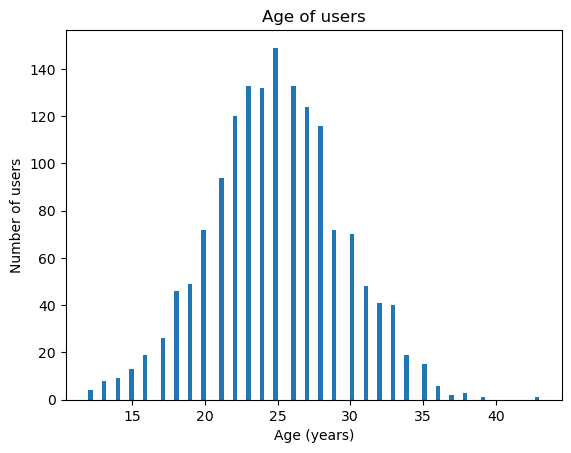

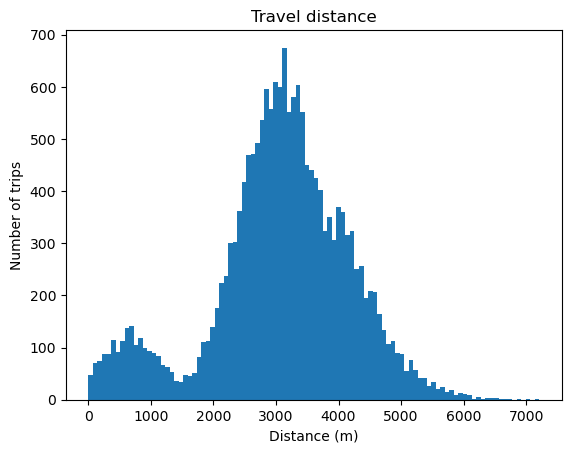

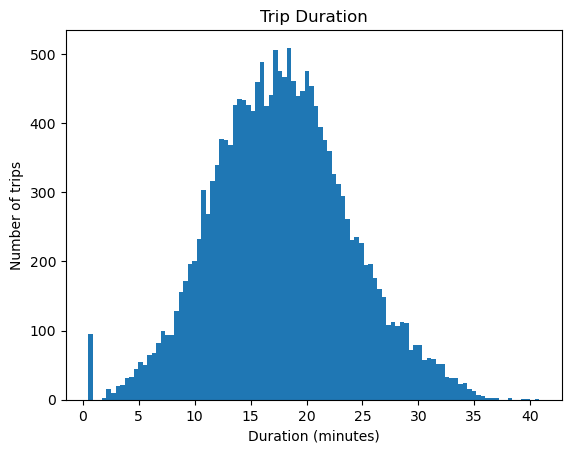

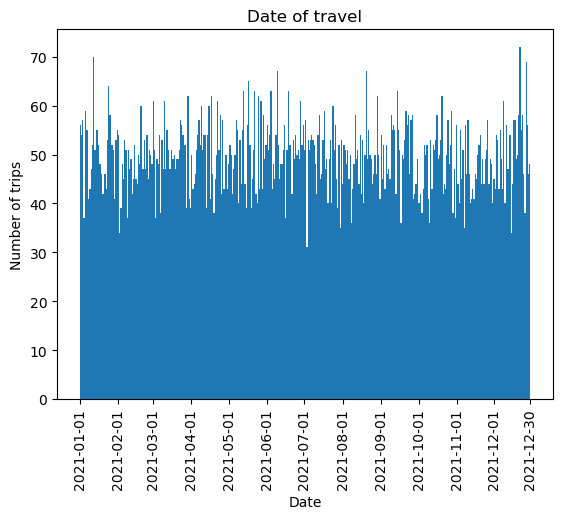

In [40]:
plt.hist(users_go['age'], bins=100)
plt. title('Age of users')
plt.xlabel('Age (years)')
plt.ylabel('Number of users')
plt.show()

plt.hist(rides_go['distance'], bins=100)
plt. title('Travel distance')
plt.xlabel('Distance (m)')
plt.ylabel('Number of trips')
plt.show()

plt.hist(rides_go['duration'], bins=100)
plt. title('Trip Duration')
plt.xlabel('Duration (minutes)')
plt.ylabel('Number of trips')
plt.show()

plt.hist(rides_go['date'].sort_values(), bins=len(rides_go['date'].unique()))
plt.title('Date of travel')
plt.xlabel('Date')
plt.xticks(rotation=90)
labels = ['2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01', '2021-12-30'] 
x = ['2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01', '2021-12-30'] 
plt.xticks(x, labels, rotation ='vertical')
plt.ylabel('Number of trips')
plt.show();

From the general information about the data in the dataframes we can conclude that:


- users_go 1565 records, no skips, the number of apparent duplicates is 31.
- users_go 18068 records, no skips, no obvious duplicates.
- subscriptions_go 2 records, no skips, no obvious duplicates.


Several columns have incorrect data type. The data can be recognized as complete and sufficient for the study.

# 2. Data preprocessing

Let's remove duplicates in users_go.

In [7]:
users_go = users_go.drop_duplicates()

In rides_go, let's do the following:
- Round the distance in meters to two decimal places.
- Round the trip duration to integers in accordance with the refined data (section 5.2) and convert it to int.
- Let's convert the date column to datetime64 format.
- Create a month column containing the month number from the date column.

In [41]:
rides_go['distance'] = rides_go['distance'].round(2)
rides_go['duration'] = np.ceil(rides_go['duration']).astype('int')
rides_go['date'] = pd.to_datetime(rides_go['date'], format='%Y-%m-%d')
rides_go['month'] = rides_go['date'].dt.month

In [42]:
print('Records with ', rides_go['date'].min(), ' by', rides_go['date'].max())

Records with  2021-01-01 00:00:00  by 2021-12-30 00:00:00


Results of data preprocessing:
- removed duplicates in users_go


The following changes were made in rides_go:
- Rounded the distance in meters to two decimal places.
- Rounded the trip duration to integers in accordance with the refined data (section 5.2) and converted it to int.
- We converted the date column to datetime64 format.
- Created a month column containing the month number from the date column.


- The subscriptions_go column was left unchanged.

# 3. Exploratory data analysis

**3.1 Analyze the frequency of occurrence of cities in our data sample.

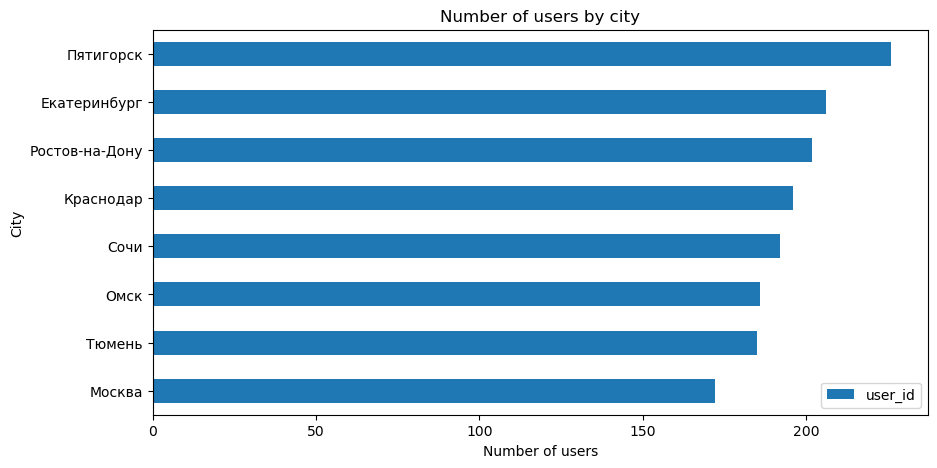

Number of users by city 


,user_id
city,
Пятигорск,226
Екатеринбург,206
Ростов-на-Дону,202
Краснодар,196
Сочи,192
Омск,186
Тюмень,185
Москва,172


In [44]:
(
    users_go.pivot_table(index='city', values='user_id', aggfunc='count').sort_values(by='user_id', ascending=True)
    .plot(kind='barh', figsize=(10, 5))
)
plt. title('Number of users by city')
plt.xlabel('Number of users')
plt.ylabel('City')

plt.show()
print('Number of users by city ')
users_go.pivot_table(index='city', values='user_id', aggfunc='count').sort_values(by='user_id', ascending=False)

According to the graph, we can conclude that Pyatigorsk is in the lead in terms of the number of users of the app, followed by Yekaterinburg and Rostov-on-Don. Despite the potentially larger number of users, Moscow is only on the eighth position - this may be due to increased competition from other scooter rental companies. Yekaterinburg, the only city out of the five that is not located in the south, is also in the top five. The leadership of southern cities in the number of scooter rental users can be explained by a longer summer period.

**3.2 Let's look at the ratio of subscribed and unsubscribed users.**

A pie-chart would be the clearest way to build a pie-chart:

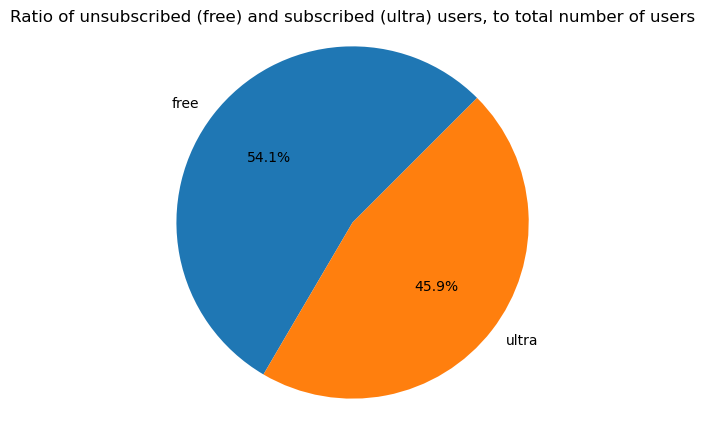

In [46]:
(
    users_go.pivot_table(index='subscription_type', values='user_id', aggfunc='count')
    .plot.pie(y='user_id', figsize=(5,5),  label='',  # Remove the y-axis caption
    autopct='%1.1f%%', startangle=45, 
    title='Ratio of unsubscribed (free) and subscribed (ultra) users, to total number of users', 
    legend=False)  # Disable the legend
)
plt.axis('equal')
plt.show()

More users use the free version of the subscription: 54.4% vs. 45.6% who use the paid subscription.

**3.3 Analyze the age of the users of the application**

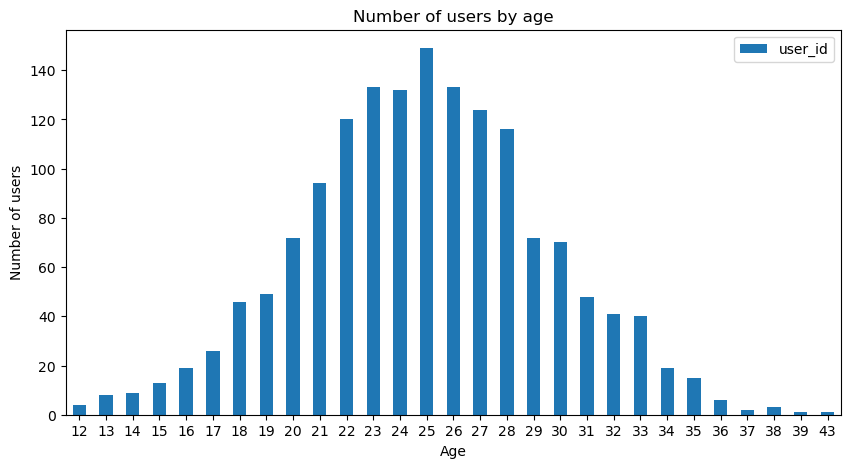

In [47]:
(
    users_go.pivot_table(index='age', values='user_id', aggfunc='count').sort_values(by='age', ascending=True)
    .plot(kind='bar', figsize=(10, 5), rot=0)  # Rotate the X-axis marks
)
plt. title('Number of users by age')
plt.xlabel('Age')
plt.ylabel('Number of users')
plt.show()


In [48]:
print('Average age of users', users_go['age'].mean().round(1))
users_go['age'].describe()

Average age of users 24.9


count    1565.000000
mean       24.922045
std         4.553496
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

The graph of the distribution of the number of users by age shows that the average age of users of the service obeys a normal distribution with a median of about 25 years.

**3.4 Estimate the distance traveled by the user in one trip.

In [49]:
rides_go['distance'].describe()

count    18068.000000
mean      3070.659992
std       1116.831222
min          0.860000
25%       2543.227500
50%       3133.610000
75%       3776.220000
max       7211.010000
Name: distance, dtype: float64

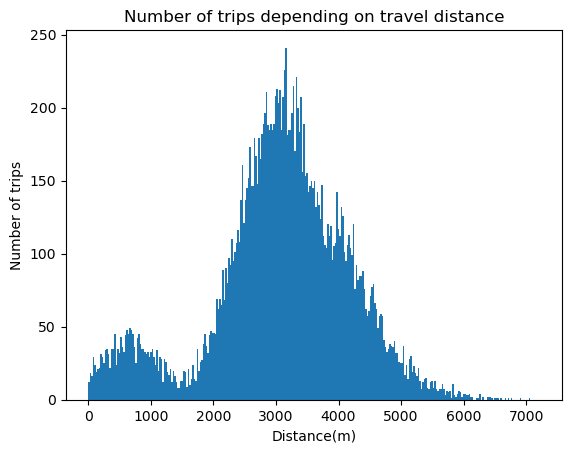

In [50]:
plt.hist(rides_go['distance'], bins=300, range=(1,7211))
plt. title('Number of trips depending on travel distance')
plt.xlabel('Distance(m)')
plt.ylabel('Number of trips')
plt.show()

- Most trips have distances between 2,000 and 4,000 meters. The distribution peaks at about 3000 meters, where the number of trips reaches a maximum (about 250).
- Very short trips (less than 1000 meters) are less frequent, but their number is still noticeable.
- After the peak at 3000 meters, the number of trips steadily decreases, although trips up to 5000 meters are still relatively frequent.
- The median is 3133.61 meters. This is close to the mean value, indicating that the distribution is symmetrical around the mean value.
- The standard deviation is 1116.83 meters, indicating a significant spread of values. This can be seen in the graph: although the main cluster of trips is centered around 3000 meters, the data is spread over a wide range of distances.


The first peak can most likely be explained by a scooter use scenario in which the user needs to quickly get, for example, from the subway or bus stop to work - usually such distances do not exceed 1km. The second peak is a usage scenario in which the scooter is the main means of transportation from point A to point B.

**3.5 Let's analyze the travel time**

In [51]:
rides_go['duration'].describe()

count    18068.000000
mean        18.303520
std          6.094928
min          1.000000
25%         14.000000
50%         18.000000
75%         22.000000
max         41.000000
Name: duration, dtype: float64

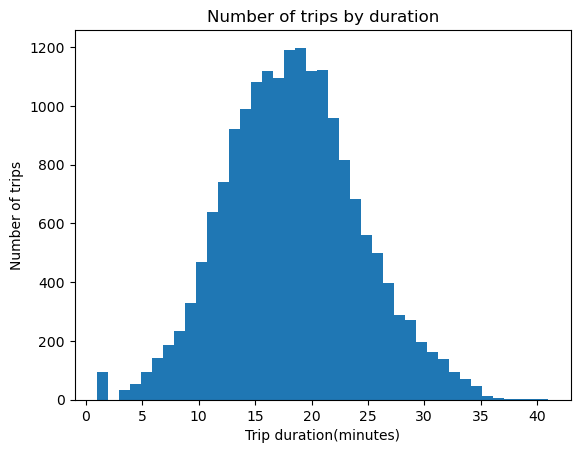

In [52]:
plt.hist(rides_go['duration'], bins=41, range=(1,41))
plt. title('Number of trips by duration')
plt.xlabel('Trip duration(minutes)')
plt.ylabel('Number of trips')
plt.show()

- The average trip duration is 18.5 minutes. This value on the graph is close to the peak of the distribution.
- The standard deviation is 6.09 minutes, indicating a moderate variation in the data. Although most of the trips are centered around the mean, the graph shows a noticeable number of trips with both shorter and longer durations.
- The histogram shows about a hundred trips of about a minute in length, possibly users who unlocked the scooter but didn't go anywhere.

Results of the research data analysis:
- According to the visualization data, we can conclude that the leader in terms of the number of scooter rental users is Pyatigorsk, followed by Yekaterinburg and Rostov-on-Don. Despite the fact that Moscow potentially has a large number of users, it occupies only the eighth position, which may be due to the high competition in the scooter rental market from other companies.
An interesting observation is the fact that Ekaterinburg is the only city in the top five that is not located in the south of Russia. The dominance of southern cities can be explained by the longer summer season, which increases the length of time favorable for scooter use.
- The data also shows that more users prefer the free version of the subscription - 54.4% vs. 45.6% using a paid subscription. This may indicate that many users either do not see the need for a paid subscription, or are just starting to use the service and are not ready to pay for services immediately.
- The distribution of users by age obeys a normal distribution. The average age of scooter rental users is about 25 years old, and this value coincides with the median, indicating that the distribution is symmetrical.
- Most trips are between 2000 and 4000 meters long, with a peak at 3000 meters, where the number of trips reaches a maximum of about 250. This means that most users choose medium length trips. The median trip distance is 3133.61 meters, which is very close to the mean value. This indicates that the distribution of the data is relatively symmetrical around the mean.
- The average trip duration is 18.5 minutes, which also corresponds to a peak in the distribution graph. The graph also contains trips with a minimum duration of about one minute. This could mean that some users unlocked the scooter but did not make a trip for some reason, which could lead to such short time entries.

# 4. Data merging

**4.1 Combine user, trip and subscription data into one dataframe.

In [18]:
df = pd.merge(users_go, subscriptions_go, on='subscription_type')
df = pd.merge(rides_go, df, on='user_id')

In [53]:
print('Number of apparent duplicates in `df` =', df.duplicated().sum(), '\n')
df.info()

Number of apparent duplicates in `df` = 0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   distance           18068 non-null  float64       
 2   duration           18068 non-null  int32         
 3   date               18068 non-null  datetime64[ns]
 4   month              18068 non-null  int32         
 5   name               18068 non-null  object        
 6   age                18068 non-null  int64         
 7   city               18068 non-null  object        
 8   subscription_type  18068 non-null  object        
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int32(2), int64(5), object(3)
memory u

In [54]:
df.head()


,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.92,26,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.59,16,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.16,7,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.78,19,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.69,27,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


We have merged two tables:
- First, we merged users_go and subscriptions_go by subscription_type column. This merged the user data with the subscription information associated with each subscription type.
- We then merged the result with the rides_go table using the user_id column, which merged the trip information with the user profiles and subscriptions.
- After merging, a check for obvious duplicates was performed. The result showed that the number of duplicates is zero, which indicates that the data merge is correct and there are no duplicate records.


Bottom line:
As a result of the merge, all the required data has been collected into a single dataframe.
The dataframe is ready for further analysis because:
- It is free of omissions and duplicates.
- Data formats are brought to the correct state.
- The total data volume is 18068 records, which is sufficient for statistical calculations and visualizations.


**4.2 Create two dataframes: one with data about subscribed and one without subscription.**

In [55]:
df_free = df[df['subscription_type'] == 'free']
df_free.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
6500,700,2515.69,15,2021-01-02,1,Айдар,22,Омск,free,8,50,0
6501,700,846.93,17,2021-02-01,2,Айдар,22,Омск,free,8,50,0
6502,700,4004.43,21,2021-02-04,2,Айдар,22,Омск,free,8,50,0
6503,700,1205.91,10,2021-02-10,2,Айдар,22,Омск,free,8,50,0
6504,700,3047.38,18,2021-02-14,2,Айдар,22,Омск,free,8,50,0


In [56]:
df_ultra = df[df['subscription_type'] == 'ultra']
df_ultra.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.92,26,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.59,16,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.16,7,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.78,19,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.69,27,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


In [57]:
total_length = len(df_free) + len(df_ultra)
df_length = len(df)

if df_length == total_length:
    print('Dataframe separation was successful')
else:
    print('Dataframe separation failed with errors')

Dataframe separation was successful


**4.3 Visualize distance and travel time information for users of both categories.**


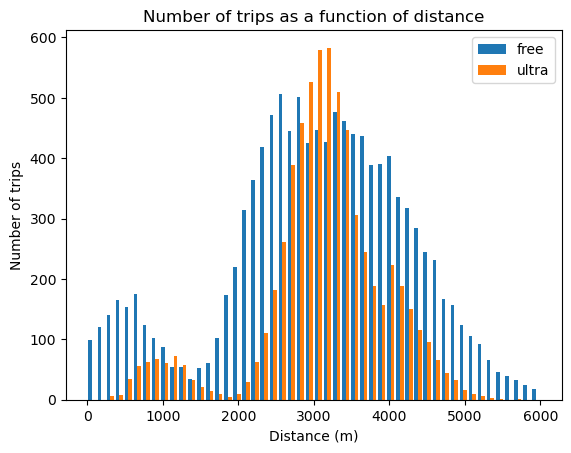

In [58]:
plt.hist([df_free['distance'], df_ultra['distance']], bins=50, range=(1, 6000), label=['free', 'ultra'])
plt.legend()
plt. title('Number of trips as a function of distance')
plt.xlabel('Distance (m)')
plt.ylabel('Number of trips')
plt.show()

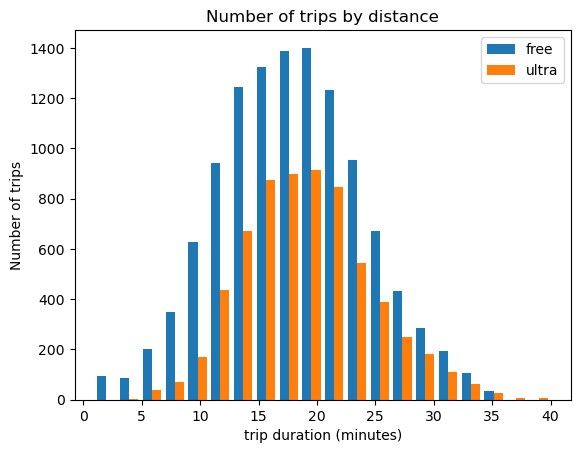

In [59]:
plt.hist([df_free['duration'], df_ultra['duration']], bins=20, range=(1,40), label=['free', 'ultra'])
plt.legend()
plt. title('Number of trips by distance')
plt.xlabel('trip duration (minutes)')
plt.ylabel('Number of trips')
plt.show()

In [60]:
df_free['distance'].describe()

count    11568.000000
mean      3045.495284
std       1246.173810
min          0.860000
25%       2366.560000
50%       3114.650000
75%       3905.695000
max       7211.010000
Name: distance, dtype: float64

In [61]:
df_ultra['distance'].describe()


count    6500.000000
mean     3115.445431
std       836.895369
min       244.210000
25%      2785.447500
50%      3148.640000
75%      3560.577500
max      5699.770000
Name: distance, dtype: float64

In [62]:
df_free['duration'].describe()


count    11568.000000
mean        17.890992
std          6.330250
min          1.000000
25%         13.000000
50%         18.000000
75%         22.000000
max         35.000000
Name: duration, dtype: float64

In [63]:
df_ultra['duration'].describe()


count    6500.000000
mean       19.037692
std         5.577439
min         4.000000
25%        15.000000
50%        19.000000
75%        22.000000
max        41.000000
Name: duration, dtype: float64

*Conclusion on combining and visualizing user data with free and ultra subscriptions:*

- Although the average distances traveled by Free and Ultra users are similar, Free users show greater variability, sometimes traveling significantly longer distances.
- Ultra users tend to travel more constant and moderate distances, with fewer emissions than Free users.
- Ultra users on average have longer trips with less variability in duration. The difference between their mean and median is smaller, indicating less variability.
- Free users show a wider range in trip duration, with a greater number of both short and long trips.


Thus, the type of subscription has an impact on both distance and length of trips.

# 5. Revenue calculation

**5.1 Create a dataframe with aggregated travel data based on the dataframe with aggregated data from step 4: find the total distance, number of trips, and total time for each user for each month.**

In [64]:
revenue = df.pivot_table(
    index=('user_id', 'month', 'subscription_type'),  # Add subscription_type to the index
    values=(
        'distance', 
        'duration', 
        'minute_price', 
        'start_ride_price', 
        'subscription_fee'
    ), 
    aggfunc={
        'distance': {'count', 'sum'}, 
        'duration': 'sum',
        'minute_price': 'mean',
        'start_ride_price': 'mean',
        'subscription_fee': 'mean'
    }
)

revenue.columns = [
    'count', 'distance', 
    'duration', 
    'minute_price',
    'start_ride_price', 
    'subscription_fee'
]

revenue.head()


count  distance  duration  minute_price  \
user_id month subscription_type                                            
1       1     ultra                  2   7027.51        42           6.0   
        4     ultra                  1    754.16         7           6.0   
        8     ultra                  2   6723.47        46           6.0   
        10    ultra                  2   5809.91        32           6.0   
        11    ultra                  3   7003.50        56           6.0   

                                 start_ride_price  subscription_fee  
user_id month subscription_type                                      
1       1     ultra                           0.0             199.0  
        4     ultra                           0.0             199.0  
        8     ultra                           0.0             199.0  
        10    ultra                           0.0             199.0  
        11    ultra                           0.0             199.0

**5.2 In the same dataframe, let's add a column with the monthly revenue that each user brought in.**

In [65]:
revenue['revenue'] = (
revenue['start_ride_price']*revenue['count']+
revenue['minute_price']*revenue['duration']+
revenue['subscription_fee'])

print('Записи с ', df['date'].min(), 'по', df['date'].max())
print ('Выручка за 2021 год:',revenue['revenue'].sum(), 'рублей.')

Записи с  2021-01-01 00:00:00 по 2021-12-30 00:00:00
Выручка за 2021 год: 3878641.0 рублей.


The annual revenue of the scooter rental service "GoFast" amounted to 3,878,641 rubles.

# 6. Hypothesis testing

**6.1 Let's test whether users with a subscription spend more time traveling.


Let's formulate the following hypotheses:


- H0: The average duration of subscription trips is equal to the average duration of non-subscription trips.


- H1: The average duration of subscription trips is greater than the average duration of non-subscription trips.


To test these hypotheses, we use the raw data on the duration of each session, dividing them into subscription and non-subscription user groups.

In [66]:
p_value = st.ttest_ind(df_ultra['duration'], df_free['duration'], equal_var=True, alternative='greater').pvalue
print(p_value)

# Testing the hypothesis
if p_value < 0.05:
    print('Rejecting the null hypothesis.')
else:
    print('Do not reject the null hypothesis.')

2.4959453720736625e-34
Rejecting the null hypothesis.


**Conclusion**: Since the p-value is significantly less than the significance level of α = 0.05, we reject the null hypothesis. This means that the average duration of trips with subscription is statistically significantly higher than the average duration of trips without subscription.

**6.2 Let's check whether the average distance of one trip of users with subscriptions exceeds 3130 meters, which is optimal in terms of scooter wear and tear.**

Let us formulate the following hypotheses:
- H0: The average distance per trip of users with Ultra subscription is equal to the optimal value of 3130 meters.
- H1: The average distance per trip of users with Ultra subscription exceeds the optimal value of 3130 meters.


Let's check the hyotheses:

In [67]:
optimal_distance = 3130
alpha = 0.05

p_value = st.ttest_1samp(df_ultra['distance'], optimal_distance, alternative='greater').pvalue
print(f"P-value: {p_value}")

# Проверяем гипотезу
if p_value < alpha:
    print('Rejecting the null hypothesis')
else:
    print('Do not reject the null hypothesis')

P-value: 0.9195362605842414
Do not reject the null hypothesis


**Conclusion:**
Since the obtained p-value (0.9195) is significantly higher than the significance level of α = 0.05, we cannot reject the null hypothesis. This means that based on the presented data, there is no statistically significant evidence that the average distance per trip of users with Ultra subscription exceeds the optimal value of 3130 meters.

**6.3 Let's test the hypothesis of whether the monthly revenue from users with subscriptions will be higher by month than the revenue from users without subscriptions.** **

Let's formulate the following hypotheses:
- H0: The average monthly revenue from users with subscription is equal to the average monthly revenue from users without subscription.


- H1: The average monthly revenue from subscribed users exceeds the average monthly revenue from non-subscribed users.

In [68]:
alpha = 0.05

revenue_with_sub = revenue[revenue['subscription_fee'] > 0]['revenue']
revenue_without_sub = revenue[revenue['subscription_fee'] == 0]['revenue']

t_stat, p_value = st.ttest_ind(revenue_with_sub, revenue_without_sub, equal_var=True, alternative='greater')

print(f"P-value: {p_value:.4e}")

# Testing the hypothesis
if p_value < alpha:
    print('Rejecting the null hypothesis.')
else:
    print('Do not reject the null hypothesis.')


P-value: 1.8850e-31
Rejecting the null hypothesis.


**Conclusion**: Since the obtained p-value is significantly less than the significance level of α = 0.05, we reject the null hypothesis. This indicates that there is a statistically significant difference in the monthly average revenue between users with and without subscription.


The average monthly revenue from subscribed users is significantly higher than the average monthly revenue from non-subscribed users.

**6.4. Let's analyze a situation: the technical team of the service has updated the servers with which the mobile application interacts. They hope that because of this the number of calls to technical support has significantly decreased. Some file contains data for each user about the number of calls before and after the update. What test would you need to test this hypothesis?

To test the hypothesis that server upgrades led to a significant decrease in the number of support calls, a paired t-test (t-test for dependent samples) should be used.
If the same variable is measured twice for the same users and the samples are equal in size, the scipy.stats.ttest_rel() method can be used.

**General Conclusions**:

- The graph showing the distribution of the number of users by city shows that Pyatigorsk leads in the number of users of the app, followed by Yekaterinburg and Rostov-on-Don. Despite its potentially larger population, Moscow ranks only eighth, possibly due to high competition among rental companies. In the top five, Ekaterinburg stands out as the only city not located in the south of Russia. The predominance of southern cities can be explained by the longer summer period, which increases the use of scooters.
- We found that more users use the free version of the subscription: 54.4% vs. 45.6% of paid users.
- The graph of user age distribution showed that the average age of the application users is normally distributed, with a median of about 25 years old.

Analyzing the number of trips as a function of distance showed the following:
- Most trips are between 2000 and 4000 meters, with the highest number around 3000 meters.
- Short trips (less than 1000 meters) are less frequent, but their number is noticeable.
- Long trips after 3000 meters become less frequent, although up to 5000 meters are still quite common.
- The average trip distance is about 3134 meters, which shows an even distribution.
- The variety of trips is large: most are around 3000 meters, but there are both significantly shorter and longer trips.

- The average trip duration is 18.5 minutes, which also corresponds to the peak in the distribution graph. The graph also contains trips with a minimum duration of about one minute. This could mean that some users unlocked the scooter but did not make a trip for some reason, which could lead to such short time entries.

The type of subscription has been shown to have an impact on both distance and length of trips:
- Although the average distances traveled by Free and Ultra users are similar, Free fare users show greater variability, sometimes traveling significantly longer distances.
- Ultra users tend to travel more constant and moderate distances, with fewer emissions than Free users.
- Ultra users on average have longer trips with less variability in duration. The difference between their mean and median is smaller, indicating less variability.
- Free fare users show a wider range in trip duration, with more both short and long trips.

The annual revenue of the scooter rental service "GoFast" amounted to 3,878,641 rubles.

Based on the results of hypothesis testing, the following can be concluded:
- Users with subscription make longer trips on average than those without subscription.
- The average trip distance of subscribers does not exceed the optimal 3,130 meters.
- Subscribers generate more monthly revenue than non-subscribers.

As a bottom line, it can be argued that users with subscriptions are more valuable to the scooter rental service.